In [1]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [3]:
class Config:
    DATA_DIR='./data/'
    IMAGES_DIR=f'{DATA_DIR}images/'
    LABELS_DIR=f'{DATA_DIR}labels/'
    PATCH_SIZE=224
    PATCH_STEP=112
    NUM_CLASSES=7
    PALETTE = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    BATCH_SIZE = 16
    NUM_WORKERS = 0

#### Подготовка датасета

In [4]:
class LabelConverter:
    def __init__(self, palette):
        self.palette = palette
        self.revert_palette = {v: k for k, v in self.palette.items()}
    

    def convert_to_image(self, label):
        image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

        for klass, color in self.palette.items():
            m = label == klass
            image[m] = color

        return image

    def convert_to_label(self, image):
        image = image.transpose(1, 2, 0)
        label = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        for color, klass in self.revert_palette.items():
            m = np.all(image == np.array(color).reshape(1, 1, 3), axis=2)
            label[m] = klass

        return label

label_converter = LabelConverter(Config.PALETTE)

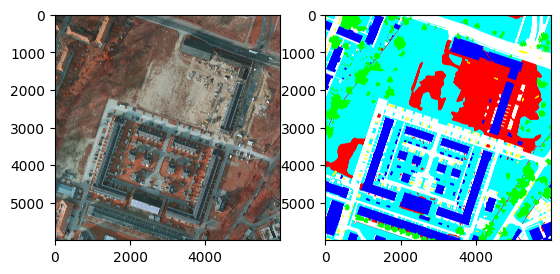

In [5]:
# We load one tile from the dataset and we display it
img = io.imread(f'{Config.IMAGES_DIR}top_potsdam_2_10_IRRG.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread(f'{Config.LABELS_DIR}top_potsdam_2_10_label.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

In [6]:
import torch
from torch.utils.data import Dataset
import os

class Patcher:
    def __init__(self, patch_size, step):
        self.patch_size = patch_size
        self.step = step


    def get_patches_data(self, image):
        image_size = image.shape
        data = []
        for x in range(0, image_size[1] - self.patch_size, self.step):
            for y in range(0, image_size[0] - self.patch_size, self.step):
                data.append((x, y))

        return data
    

    def get_patch(self, image, x_y):
        x, y = x_y
        return image[y:y + self.patch_size, x:x + self.patch_size, :]



class ISPRSDataset(Dataset):
    def __init__(self, patcher, label_converter, images_dir, labels_dir, cache=False):
        super(ISPRSDataset, self).__init__()
        
        self.patcher = patcher
        self.label_converter = label_converter

        self.cache = cache
        # self._image_patches_cache = []
        # self._label_patches_cache = []
        self._images_cache = []
        self._label_images_cache = []

        self.image_files = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.tif')]
        self.label_files = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith('.tif')]
        

        assert len(self.image_files) == len(self.label_files), "Count of images and labels doesn't match!"

        self.patches_data = []
        self.indexes = []
        print("Start calculating meta-data...")
        for idx, image_file in enumerate(self.image_files):
            print(f"{idx}/{len(self.image_files)}")
            image = io.imread(image_file)
            if self.cache:
                label_image = io.imread(self.label_files[idx])
                self._images_cache.append(image)
                self._label_images_cache.append(label_image)
            data = self.patcher.get_patches_data(image)
            self.patches_data.extend(data)
            self.indexes.extend([idx] * len(data))

        print(f"Created dataset with {len(self.patches_data)} patches from {len(self.image_files)} images")

        # if self.cache:
        #     print("Start filling cache...")
        #     current_idx = None
        #     for idx in range(len(self)):
        #         if idx % 100 == 0:
        #             print(f"{idx}/{len(self)}")

        #         patch_data = self.patches_data[idx]
        #         if current_idx is None or current_idx != self.indexes[idx]:
        #             image_file = self.image_files[self.indexes[idx]]
        #             label_file = self.label_files[self.indexes[idx]]
        #             image = io.imread(image_file)
        #             label_image = io.imread(label_file)
        #             current_idx = self.indexes[idx]
        #         image_patch_tensor, label_patch_tensor = self._get_patches(image, label_image, patch_data)
        #         self._image_patches_cache.append(image_patch_tensor)
        #         self._label_patches_cache.append(label_patch_tensor)
        #     print("Done")

            
    def __len__(self):
        return len(self.patches_data)
    
    
    def __getitem__(self, idx):
        if self.cache:
            patch_data = self.patches_data[idx]
            image = self._images_cache[self.indexes[idx]]
            label_image = self._label_images_cache[self.indexes[idx]]

            return self._get_patches(image, label_image, patch_data)
        else:
            patch_data = self.patches_data[idx]
            image_file = self.image_files[self.indexes[idx]]
            label_file = self.label_files[self.indexes[idx]]

            image = io.imread(image_file)
            label_image = io.imread(label_file)

            return self._get_patches(image, label_image, patch_data)
    
    
    def _get_patches(self, image, label_image, patch_data):
        image_patch = np.asarray(self.patcher.get_patch(image, patch_data).transpose((2,0,1)), dtype='float16') / 255
        label_image_patch = np.asarray(self.patcher.get_patch(label_image, patch_data).transpose((2,0,1)), dtype='int8')
        label_patch = self.label_converter.convert_to_label(label_image_patch)

        return (
            torch.from_numpy(image_patch).float(),
            torch.from_numpy(label_patch).long()
        )

In [7]:
dataset = ISPRSDataset(
    Patcher(Config.PATCH_SIZE, Config.PATCH_STEP), 
    LabelConverter(Config.PALETTE), 
    Config.IMAGES_DIR,
    Config.LABELS_DIR, 
    cache=True)

Start calculating meta-data...
0/24
1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
Created dataset with 64896 patches from 24 images


#### Модель

In [8]:
import torch.nn as nn
from transformers import ViTModel

class ViTForSemanticSegmentation(nn.Module):
    def __init__(self, num_classes, img_size=Config.PATCH_SIZE, patch_size=16):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        
        # ViT энкодер
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.hidden_size = self.vit.config.hidden_size
        
        # Декодер (простой вариант)
        self.decoder = nn.Sequential(
            nn.Conv2d(self.hidden_size, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, num_classes, 1)
        )
        
    def forward(self, x):
        # ViT энкодер
        outputs = self.vit(x)
        last_hidden_state = outputs.last_hidden_state  # [batch, seq_len, hidden]
        
        # Извлекаем патч эмбеддинги (исключаем cls token)
        patch_embeddings = last_hidden_state[:, 1:]  # [batch, num_patches, hidden]
        
        # Решейп в 2D feature map
        batch_size = x.size(0)
        num_patches = patch_embeddings.size(1)
        grid_size = int(num_patches ** 0.5)  # предполагаем квадратное изображение
        
        features = patch_embeddings.permute(0, 2, 1).view(
            batch_size, self.hidden_size, grid_size, grid_size
        )
        
        # Декодер и интерполяция до исходного размера
        logits = self.decoder(features)
        logits = nn.functional.interpolate(
            logits, 
            size=self.img_size, 
            mode='bilinear', 
            align_corners=False
        )
        
        return logits

#### Обучение

In [9]:
class Logger:
    pass #TODO Логирование метрик в файл, на сервер или в MLFlow и т.п.

In [10]:
from tqdm import tqdm

class ViTTrainer:
    def __init__(self, model, num_classes, opimizer, scheduler, train_loader, val_loader, device, logger):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=255)
        self.optimizer = opimizer
        self.scheduler = scheduler

        self.train_losses = []
        self.val_losses = []
        self.val_iou_scores = []
        
        self.logger = logger
        
    def train_epoch(self):
        """Одна эпоха обучения"""
        self.model.to(self.device)
        self.model.train()
        running_loss = 0.0
        
        pbar = tqdm(self.train_loader, desc="Training")
        for images, labels in pbar:
            # Перемещаем данные на устройство
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)
            
            # Вычисляем loss
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Обновляем статистику
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        epoch_loss = running_loss / len(self.train_loader)

        self.train_losses.append(epoch_loss)

        return epoch_loss
    
    def validate_epoch(self):
        """Валидация после эпохи"""
        self.model.eval()
        running_loss = 0.0
        total_iou = 0.0
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validation"):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                
                # Вычисляем IoU
                iou = self.calculate_iou(outputs, labels)
                total_iou += iou
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_iou = total_iou / len(self.val_loader)

        self.val_losses.append(epoch_loss)
        self.val_iou_scores.append(epoch_iou)

        return epoch_loss, epoch_iou
    
    def calculate_iou(self, outputs, labels):
        """Вычисляет Intersection over Union"""
        # Получаем предсказанные классы
        preds = torch.argmax(outputs, dim=1)
        
        ious = []
        for class_id in range(self.num_classes):
            pred_mask = (preds == class_id)
            true_mask = (labels == class_id)
            
            intersection = (pred_mask & true_mask).float().sum()
            union = (pred_mask | true_mask).float().sum()
            
            if union > 0:
                iou = intersection / union
                ious.append(iou.item())
        
        return np.mean(ious) if ious else 0.0
    
    def train(self, num_epochs, save_path='best_model.pth'):
        """Полный цикл обучения"""
        print(f"Starting training for {num_epochs} epochs on {self.device}")
        
        best_iou = 0.0
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            # Обучение
            train_loss = self.train_epoch()
            
            # Валидация
            val_loss, val_iou = self.validate_epoch()
            
            # Обновляем learning rate
            self.scheduler.step()
            
            # Выводим статистику
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f} | LR: {current_lr:.2e}")
            
            # TODO
            # self.logger.log({
            #     'train_loss': train_loss,
            #     'val_loss': val_loss,
            #     'val_iou': val_iou,
            #     'lr': current_lr
            # })
            
            # Сохраняем лучшую модель
            if val_iou > best_iou:
                best_iou = val_iou
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_iou': val_iou,
                    'val_loss': val_loss
                }, save_path)
                print(f"New best model saved with IoU: {val_iou:.4f}")
        
        print(f"\nTraining completed! Best IoU: {best_iou:.4f}")
        
    def plot_training_history(self):
        """Визуализация процесса обучения"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # IoU
        ax2.plot(self.val_iou_scores, label='Val IoU', color='green')
        ax2.set_title('Validation IoU')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('IoU')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

In [11]:
from torch.utils.data import DataLoader, random_split
import time
import torch.multiprocessing as mp

dataset_size = len(dataset)
train_size = int(Config.TRAIN_RATIO * dataset_size)
val_size = int(Config.VAL_RATIO * dataset_size)
test_size = dataset_size - train_size - val_size

# Разделяем датасет
train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # для воспроизводимости
)

print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples") 
print(f"Test: {len(test_dataset)} samples")

# Создаем DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=Config.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=Config.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=Config.NUM_WORKERS)

Train: 45427 samples
Val: 9734 samples
Test: 9735 samples


In [12]:
model = ViTForSemanticSegmentation(Config.NUM_CLASSES, Config.PATCH_SIZE, 16)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #По
logger = Logger()

trainer = ViTTrainer(
    model,
    Config.NUM_CLASSES,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    device,
    logger
)

In [14]:
trainer.train(5)

Starting training for 5 epochs on cuda

Epoch 1/5
--------------------------------------------------


Training:   0%|                                                                               | 0/2840 [00:00<?, ?it/s]C:\Users\Alexander\AppData\Local\Temp\ipykernel_7684\3093281575.py:45: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  running_loss += loss.item()
Validation: 100%|████████████████████████████████████████████████████████████████████| 609/609 [03:30<00:00,  2.89it/s]


Train Loss: 0.0109 | Val Loss: 0.0001 | Val IoU: 1.0000 | LR: 1.00e-03
New best model saved with IoU: 1.0000

Epoch 2/5
--------------------------------------------------


Training:  10%|█████▎                                                  | 271/2840 [03:27<32:50,  1.30it/s, Loss=0.0001]


KeyboardInterrupt: 

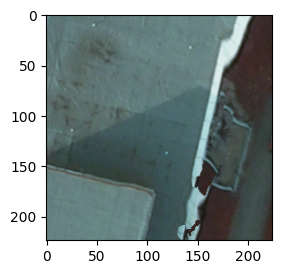

In [25]:
img, label = test_loader.__iter__().__next__()
label = label.numpy()[0]
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img.numpy()[2].transpose(1, 2, 0))

In [55]:
import torch
import numpy as np
from torch.nn import functional as F
import tifffile as tiff
import cv2

class FixedLargeImageInference:
    def __init__(self, model, patcher, label_converter, device='cuda'):
        self.model = model.to(device)
        self.model.eval()
        self.patcher = patcher
        self.label_converter = label_converter
        self.device = device
        
    def preprocess_patch(self, patch):
        """Препроцессинг патча с нормализацией ImageNet"""
        patch_tensor = torch.from_numpy(patch).permute(2, 0, 1).float() / 255.0
        
        # ImageNet нормализация
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        patch_tensor = (patch_tensor - mean) / std
        
        return patch_tensor.unsqueeze(0)
    
    def process_large_image(self, image, overlap=0.1):
        """
        Обработка большого изображения по патчам
        """
        original_shape = image.shape[:2]
        patch_size = self.patcher.patch_size
        step = int(patch_size * (1 - overlap))
        
        self.patcher.step = step
        patches_data = self.patcher.get_patches_data(image)
        
        num_classes = 7
        output_shape = (num_classes, original_shape[0], original_shape[1])
        logits_map = np.zeros(output_shape, dtype=np.float32)
        weight_map = np.zeros(original_shape, dtype=np.float32)
        
        print(f"Обрабатывается {len(patches_data)} патчей...")
        
        with torch.no_grad():
            for i, patch_data in enumerate(patches_data):
                patch = self.patcher.get_patch(image, patch_data)
                x, y = patch_data
                
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    continue
                
                # Препроцессинг
                patch_tensor = self.preprocess_patch(patch).to(self.device)
                
                # Инференс
                output = self.model(patch_tensor)
                
                # Получаем логиты
                if isinstance(output, dict):
                    logits = output['out'] if 'out' in output else output['logits']
                else:
                    logits = output
                
                logits = logits.cpu().numpy().squeeze()
                
                # Убеждаемся в формате [C, H, W]
                if len(logits.shape) == 3 and logits.shape[2] == num_classes:
                    logits = logits.transpose(2, 0, 1)
                
                # ДЕБАГ: анализируем логиты
                if i == 0:
                    print("ДЕБАГ первого патча:")
                    for c in range(num_classes):
                        class_logits = logits[c]
                        print(f"  Класс {c}: min={class_logits.min():.3f}, max={class_logits.max():.3f}, mean={class_logits.mean():.3f}")
                    
                    # Проверяем softmax для первого патча
                    temp_probs = F.softmax(torch.from_numpy(logits), dim=0)
                    pred_temp = torch.argmax(temp_probs, dim=0)
                    unique, counts = np.unique(pred_temp.numpy(), return_counts=True)
                    print(f"  Предсказание первого патча: {dict(zip(unique, counts))}")
                
                # Простое равномерное окно (убираем гауссово сглаживание)
                weights = np.ones((patch_size, patch_size), dtype=np.float32)
                
                # Агрегируем логиты
                logits_map[:, y:y+patch_size, x:x+patch_size] += logits * weights
                weight_map[y:y+patch_size, x:x+patch_size] += weights
                
                if (i + 1) % 100 == 0:
                    print(f"Обработано {i + 1}/{len(patches_data)} патчей")
        
        # Нормализация
        print("Нормализация логитов...")
        for c in range(num_classes):
            logits_map[c] = np.divide(
                logits_map[c], 
                weight_map, 
                out=np.zeros_like(logits_map[c]), 
                where=weight_map != 0
            )
        
        # ДЕБАГ: проверяем агрегированные логиты
        print("ДЕБАГ агрегированных логитов:")
        for c in range(num_classes):
            class_logits = logits_map[c]
            print(f"  Класс {c}: min={class_logits.min():.3f}, max={class_logits.max():.3f}, mean={class_logits.mean():.3f}")
        
        # Применяем softmax и получаем предсказание
        print("Применение softmax...")
        logits_tensor = torch.from_numpy(logits_map)
        probabilities = F.softmax(logits_tensor, dim=0)
        
        # ДЕБАГ: проверяем вероятности
        print("ДЕБАГ вероятностей:")
        for c in range(num_classes):
            class_probs = probabilities[c]
            print(f"  Класс {c}: min={class_probs.min():.5f}, max={class_probs.max():.5f}, mean={class_probs.mean():.5f}")
        
        final_prediction = torch.argmax(probabilities, dim=0)
        
        # Анализ результата
        unique, counts = np.unique(final_prediction.numpy(), return_counts=True)
        print(f"Финальное распределение классов: {dict(zip(unique, counts))}")
        
        return final_prediction.numpy().astype(np.uint8)

    def process_and_visualize(self, image_path, output_path=None, overlap=0.1):
        """Полный пайплайн обработки с визуализацией"""
        if isinstance(image_path, str):
            image = tiff.imread(image_path)
        else:
            image = image_path
        
        print(f"Загружено изображение: {image.shape}")
        
        # Инференс
        print("Запуск инференса...")
        prediction = self.process_large_image(image, overlap)
        
        # Конвертация в цветное изображение
        print("Конвертация в цветное представление...")
        colored_result = self.label_converter.convert_to_image(prediction)
        
        if output_path:
            tiff.imwrite(output_path, colored_result)
            print(f"Результат сохранен в: {output_path}")
        
        return prediction, colored_result

In [56]:
# Создание инференс-движка
inference_engine = LargeImageInference(
    model=model,
    patcher=patcher,
    label_converter=label_converter,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Включите отладку
print("=== ОТЛАДКА ===")
print(f"Модель на устройстве: {next(model.parameters()).device}")
print(f"Тип модели: {type(model)}")

# Обработка изображения с отладкой
prediction, colored_result = inference_engine.process_and_visualize(
    image_path="./data/images/top_potsdam_2_10_IRRG.tif",
    output_path="result.tif",
    overlap=0.1
)

=== ОТЛАДКА ===
Модель на устройстве: cuda:0
Тип модели: <class '__main__.ViTForSemanticSegmentation'>
Загружено изображение: (6000, 6000, 3)
Патч 0:
  Координаты: (0, 0)
  Размер патча: (224, 224, 3)
  Диапазон значений: [15, 123]
  Тензор форма: torch.Size([1, 3, 224, 224])
  Тензор диапазон: [0.059, 0.482]
  Выход модели тип: <class 'torch.Tensor'>
  Логиты форма: (7, 224, 224)
  Логиты диапазон: [-6.609, 6.437]
  Предсказание форма: (224, 224)
  Распределение классов: {np.int64(0): np.int64(50176)}
Запуск инференса...
Обрабатывается 841 патчей...
Размер выходной карты: (7, 6000, 6000)


KeyboardInterrupt: 